In [9]:

import numpy as np
from math import sqrt
import random
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.utils import shuffle
from sklearn.metrics import calinski_harabaz_score


# Function to read the input file and perform basic data validation
def csr_read(fname, nidx=1):
    
    with open(fname) as f:
        lines = f.readlines()
    
    nrows = len(lines)
    ncols = 0 
    nnz = 0 
    for i in range(nrows):
        p = lines[i].split()
        if len(p) % 2 != 0:
            raise ValueError("Invalid CSR matrix. Please correct the format")
        nnz += len(p)/2
        for j in range(0, len(p), 2): 
            cid = int(p[j]) - nidx
            if cid+1 > ncols:
                ncols = cid+1

    nnz=int(nnz) # to type cast float to integer values
    val = np.zeros(nnz, dtype=np.int)   #
    ind = np.zeros(nnz, dtype=np.int)
    ptr = np.zeros(nrows+1, dtype=np.long)
    n = 0 
    for i in range(nrows):
        p = lines[i].split()
        for j in range(0, len(p), 2): 
            ind[n] = int(p[j]) - nidx
            val[n] = float(p[j+1])
            n += 1
        ptr[i+1] = n 
    
    assert(n == nnz) # assertion if the number is not zero
    
    return csr_matrix((val, ind, ptr), shape=(nrows, ncols), dtype=np.float)


# scale the matrix and normalize the rows of the matrix
def csr_idf(mat, copy=False, **kargs):

    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    
# Initialise and create the document frequency with initail values
    df = defaultdict(int)
    for i in ind:
        df[i] += 1
    
# create the inverse document frequency by converting document frequency to Inverse document frequeny
    for k,v in df.items():
        df[k] = np.log(nrows / float(v))
    # Scaling by Inverse document frequency
    for i in range(0, nnz):
        val[i] *= df[ind[i]]
        
    return df if copy is False else mat



def csr_L2norm(mat, copy=False, **kargs):

    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # normalize the range of values
    for i in range(nrows):
        rsum = 0.0    
        for j in range(ptr[i], ptr[i+1]):
            rsum += val[j]**2
        if rsum == 0.0:
            
            continue  #Logic for not to the normalize empty rows
        rsum = float(1.0/np.sqrt(rsum))
        for j in range(ptr[i], ptr[i+1]):
            val[j] *= rsum
            
    if copy is True:
        return mat


# In[6]:


def prim_Centroid(mat):
    matShuffled = shuffle(mat, random_state=0)
    return matShuffled[:2,:]


# In[7]:


def simi(mat, centroids):
    similarities = mat.dot(centroids.T)
    return similarities


# In[8]:

#Sort the index of the matrix in ascending order of value and get the index of the last element
def fndClustr(mat, centroids):
    
    clust_A = list()
    clust_B = list()
    
    simimat = simi(mat, centroids)
    
    for index in range(simimat.shape[0]):
        simiRow = simimat[index]
        
        simiSorted = np.argsort(simiRow)[-1]
        
        if simiSorted == 0:
            clust_A.append(index)
        else:
            clust_B.append(index)
        
    return clust_A, clust_B


# Now recalculate the centroid based on cluster mean
def recalc_centroid(mat, clusters):
    centroids = list()
    
    for i in range(0,2):
        cluster = mat[clusters[i],:]
        clusterMean = cluster.mean(0)
        centroids.append(clusterMean)
        
    centroids_arr = np.asarray(centroids)
    
    return centroids_arr

# Logic to calculate kmeans of the clusters
def kmeans(mat, iIteration):
    
    centroids = prim_Centroid(mat)
    
    for _ in range(iIteration):
        
        clusters = list()
        
        clust_A, clust_B = fndClustr(mat, centroids)
        
        if len(clust_A) > 1:
            clusters.append(clust_A)
        if len(clust_B) > 1:
            clusters.append(clust_B)
         

        centroids = recalc_centroid(mat, clusters) #Recalculate the updated value of the centroid 
        
    return clust_A, clust_B

# Function defination to calculate the Sum of Squared Error based on its generic formula
def cal_SSE(mat, clusters):
    
    SSE_list = list()
    SSE_array = []
    
    for cluster in clusters:
        members = mat[cluster,:]
        SSE = np.sum(np.square(members - np.mean(members)))
        SSE_list.append(SSE)
        
    SSE_array = np.asarray(SSE_list)
    drop_ClusterIdx = np.argsort(SSE_array)[-1]
            
    return drop_ClusterIdx

# Functional implementation of Bisecting K-Means algorithm using pre-defined user function 
def bisecting_kmeans(mat, k, iIteration):
    
    clusters = list()
    
    initialcluster = list()
    for i in range(mat.shape[0]):
        initialcluster.append(i)
    
    clusters.append(initialcluster)
    
    while len(clusters) < k:

        drop_ClusterIdx = cal_SSE(mat, clusters)
        droppedCluster = clusters[drop_ClusterIdx]
        
        clust_A, clust_B = kmeans(mat[droppedCluster,:], iIteration)
        del clusters[drop_ClusterIdx]
        
        actualclust_A = list()
        actualclust_B = list()
        for index in clust_A:
            actualclust_A.append(droppedCluster[index])
            
        for index in clust_B:
            actualclust_B.append(droppedCluster[index])
        
        clusters.append(actualclust_A)
        clusters.append(actualclust_B)
    
    labels = [0] * mat.shape[0]

    for index, cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = index + 1
    return labels


In [10]:

#Read CSR matrix values from the input file
csrmat = csr_read('train.dat', nidx=1)

#Scale the CSR matrix by idf (Inverse Document Frequency)
csrIDF = csr_idf(csrmat, copy=True)

#Normalize the rows of a CSR matrix by their L-2 norm.
L2Normalized_csr = csr_L2norm(csrIDF, copy=True)

#Obtain a dense ndarray representation of the CSR matrix.
densemat = L2Normalized_csr.toarray()


In [11]:

kValues = list()
scores = list()

# As per requirement, run for the values of K from 3 to 21 in steps of 2 for the given dataset
for k in range(3, 22, 2):
    labels = bisecting_kmeans(densemat, k, 10)

    if (k == 7):
        # write result to output file in the .dat format
        outputFile = open("HW2_012566398.dat", "w")
        for index in labels:
            outputFile.write(str(index) +'\n')
        outputFile.close()

    score = calinski_harabaz_score(densemat, labels)
    kValues.append(k)
    scores.append(score)

    print ("For K= %d Calinski Harabaz Score is %f" %(k, score))

For K= 3 Calinski Harabaz Score is 63.080976
For K= 5 Calinski Harabaz Score is 47.311063
For K= 7 Calinski Harabaz Score is 46.035433
For K= 9 Calinski Harabaz Score is 43.216868
For K= 11 Calinski Harabaz Score is 38.217769
For K= 13 Calinski Harabaz Score is 34.761864
For K= 15 Calinski Harabaz Score is 34.206359
For K= 17 Calinski Harabaz Score is 32.649491
For K= 19 Calinski Harabaz Score is 30.837459
For K= 21 Calinski Harabaz Score is 30.097737


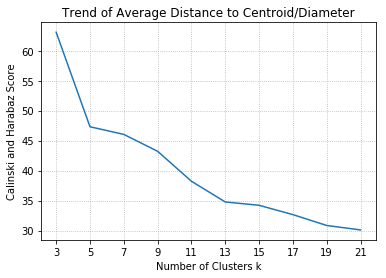

In [12]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt

plt.plot(kValues, scores)
plt.xticks(kValues, kValues)
plt.xlabel('Number of Clusters k')
plt.ylabel('Calinski and Harabaz Score')
plt.title('Trend of Average Distance to Centroid/Diameter')
plt.grid(linestyle='dotted')

plt.savefig('plot.png')
plt.show()
#Reference:GitHub repositories

In [13]:
from sklearn.metrics import silhouette_score
print(silhouette_score(densemat, labels, metric='cosine'))

0.03294407717297582


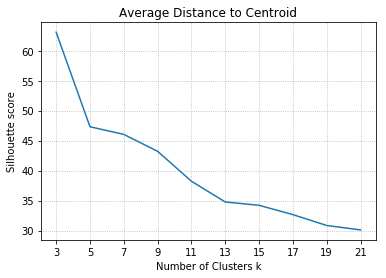

In [14]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt

plt.plot(kValues, scores)
plt.xticks(kValues, kValues)
plt.xlabel('Number of Clusters k')
plt.ylabel('Silhouette score')
plt.title('Average Distance to Centroid')
plt.grid(linestyle='dotted')

plt.savefig('plot.png')
plt.show()